In [1]:
import numpy as np
import torch
from torch import nn
from torch import functional as F
import math

In [2]:
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from livelossplot import PlotLosses

In [4]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device = 'cpu'

In [6]:
sigma_noise = 0.1
(x_data, y_data) = torch.load('foong_data.pt')
#x_data = x_data.to(device)
#y_data = y_data.to(device)

In [7]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [8]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [9]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [46]:
class ProbabilisticLinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(ProbabilisticLinear, self).__init__()
        self.softplus = torch.nn.Softplus()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.q_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.q_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.q_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.q_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.weight_epsilon = torch.Tensor(out_features, in_features)
        self.bias_epsilon = torch.Tensor(out_features, in_features)
        
        self.weight_sample = torch.Tensor(out_features, in_features)
        self.bias_sample = torch.Tensor(out_features, in_features)
        
        self.reset_parameters()
        
        mu = torch.tensor(0.0)
        rho = sigma_to_rho(torch.tensor(1.0))
        
        self.prior_weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.prior_weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.prior_bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.prior_bias_rho = nn.Parameter(torch.Tensor(out_features))
        
        self.prior_weight_mu.requires_grad = False
        self.prior_weight_rho.requires_grad = False
        self.prior_bias_mu.requires_grad = False
        self.prior_bias_rho.requires_grad = False
        
        nn.init.constant_(self.prior_weight_mu, mu)
        nn.init.constant_(self.prior_weight_rho, rho)
        nn.init.constant_(self.prior_bias_mu, mu)
        nn.init.constant_(self.prior_bias_rho, rho)
        
    def generate_rand(self):
        self.weight_epsilon = torch.randn(size=self.q_weight_mu.size())
        self.bias_epsilon = torch.randn(size=self.q_bias_mu.size())
        return (self.weight_epsilon, self.bias_epsilon)
    
    def reparameterization(self):
        sigma_weight = self.softplus(self.q_weight_rho)
        self.weight_sample = self.weight_epsilon.mul(sigma_weight).add(self.q_weight_mu)
        
        sigma_bias = self.softplus(self.q_bias_rho)
        self.bias_sample = self.bias_epsilon.mul(sigma_bias).add(self.q_bias_mu)
        return (self.weight_sample, self.bias_sample)

    def q_log_pdf(self):
        sigma_weight = self.softplus(self.q_weight_rho)
        nw = torch.distributions.Normal(self.q_weight_mu, sigma_weight)
        
        sigma_bias = self.softplus(self.q_bias_rho)
        nb = torch.distributions.Normal(self.q_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    #def q_rnd(self):
    #    sigmaw = self.softplus(self.q_weight_rho)
    #    nw = torch.distributions.Normal(self.q_weight_mu, sigmaw)
    #    sigmab = self.softplus(self.q_bias_rho)
    #    nb = torch.distributions.Normal(self.q_bias_mu, sigmab)
    #    return (nw.rsample(), nb.rsample())
    
    def prior_log_pdf(self):
        sigma_weight = self.softplus(self.prior_weight_rho)
        nw = torch.distributions.Normal(self.prior_weight_mu, sigma_weight)
        
        sigma_bias = self.softplus(self.prior_bias_rho)
        nb = torch.distributions.Normal(self.prior_bias_mu, sigma_bias)
        
        return nw.log_prob(self.weight_sample).sum() + nb.log_prob(self.bias_sample).sum()
    
    def reset_parameters(self):
        torch.nn.init.normal_(self.q_weight_mu, mean=0.0, std=1.0)
        torch.nn.init.constant_(self.q_weight_rho, -10.0)
        torch.nn.init.normal_(self.q_bias_mu, mean=0.0, std=1.0)
        torch.nn.init.constant_(self.q_bias_rho, -10.0)
       
    def forward(self, input):
        return torch.nn.functional.linear(input, self.weight_sample, self.bias_sample)

In [47]:
class RegressionModel(nn.Module):
    def __init__(self, H):
        super(RegressionModel, self).__init__()
        
        self.linear1 = ProbabilisticLinear(1, H)
        self.linear2 = ProbabilisticLinear(H,1)
        
        self.registered_layers = []
        self.registered_layers.append(self.linear1)
        self.registered_layers.append(self.linear2)
        
        self.nb_parameters = self.count_parameters()
        
    def forward(self, x):
        out = torch.tanh(self.linear1(x))
        out = self.linear2(out)
        return out
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
          
    #def generate_rand_(self):
    #    self.q_linear1.weight_epsilon = torch.randn(size=self.q_linear1.weight_mu.size())
    #    self.q_linear1.bias_epsilon = torch.randn(size=self.q_linear1.bias_mu.size())
    #    self.q_linear2.weight_epsilon = torch.randn(size=self.q_linear2.weight_mu.size())
    #    self.q_linear2.bias_epsilon = torch.randn(size=self.q_linear2.bias_mu.size())
    
    #def reparam(self):
    #    sigma = self.softplus(self.q_linear1.weight_rho)
    #    self.q_linear1.weight_sample = self.q_linear1.weight_epsilon.mul(sigma).add(self.q_linear1.weight_mu)
    #    sigma = self.softplus(self.q_linear1.bias_rho)
    #    self.q_linear1.bias_sample = self.q_linear1.bias_epsilon.mul(sigma).add(self.q_linear1.bias_mu)
    #    sigma = self.softplus(self.q_linear2.weight_rho)
    #    self.q_linear2.weight_sample = self.q_linear2.weight_epsilon.mul(sigma).add(self.q_linear2.weight_mu)
    #    sigma = self.softplus(self.q_linear2.bias_rho)
    #    self.q_linear2.bias_sample = self.q_linear2.bias_epsilon.mul(sigma).add(self.q_linear2.bias_mu)
        
    def compute_elbo(self, x_data, y_data):        
        (L1_weight_epsilon, L1_bias_epsilon) = self.linear1.generate_rand()
        (L1_weight_sample, L1_bias_sample) = self.linear1.reparameterization()
        
        (L2_weight_epsilon, L2_bias_epsilon) = self.linear2.generate_rand()
        (L2_weight_sample, L2_bias_sample) = self.linear2.reparameterization()
        
        
        LQ = self.linear1.q_log_pdf() + self.linear2.q_log_pdf()
        LP = self.linear1.prior_log_pdf() + self.linear2.prior_log_pdf()
        
        y_pred = self.forward(x_data)
        
        n = torch.distributions.Normal(y_pred, sigma_noise)
        LL = n.log_prob(y_data).sum()
        
        loss = LQ - LP - LL
        
        return loss

In [68]:
model = RegressionModel(50)

In [69]:
L = model.compute_elbo(x_data, y_data)
L.backward()

In [70]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/cortax/Anaconda3/Library/bin/graphviz/'

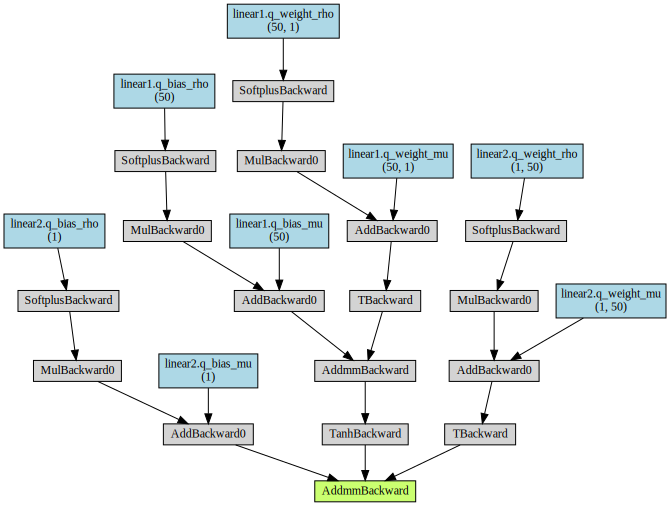

In [71]:
make_dot(model(x_data), params=dict(model.named_parameters()))

In [72]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.8,verbose=True)
optimizer.zero_grad()

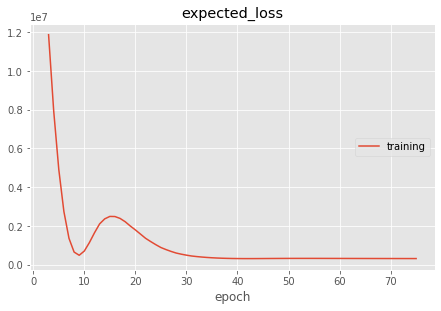

expected_loss:
training   (min: 306589.844, max: 22430836.000, cur: 308645.906)
Epoch    74: reducing learning rate of group 0 to 1.8014e-04.


KeyboardInterrupt: 

In [73]:
%matplotlib inline
num_epoch = 100
num_iterations = 1000
liveloss = PlotLosses()

for j in range(num_epoch):
    logs = {}
    losses = [None] * num_iterations
    
    for k in range(num_iterations):
        
        optimizer.zero_grad()
        loss = model.compute_elbo(x_data, y_data)
        losses[k] = loss
    
    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().numpy()
    liveloss.update(logs)
    liveloss.draw()
    
    loss.backward()
    optimizer.step()
    scheduler.step(logs['expected_loss'])
    

In [ ]:
model.linear1.q_weight_rho

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
alpha = torch.tensor(10e-5)

In [ ]:
for i in range(0,1000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)
